In [42]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import swifter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import torch.nn.functional as F
import torch
from torch.nn.functional import softmax
from zoneinfo import ZoneInfo 

In [ ]:
file_path = r"C:\Users\jiali\OneDrive - TUM\Studium\Data-Mining\physics.stackexchange.com\CSV\UsersWithCountry.csv"

df = pd.read_csv(file_path)
df = df[['Id', 'LocationCountry']]

In [25]:
df

,Id,LocationCountry
0,-1,NaN
1,2,united states
2,3,united states
3,4,united kingdom
4,5,NaN
...,...,...
319430,391197,NaN
319431,391198,NaN
319432,391199,NaN
319433,391200,NaN


In [26]:
csv_folder = r"C:\Users\jiali\OneDrive - TUM\Studium\Data-Mining\physics.stackexchange.com\CSV"
csv_path = os.path.join(csv_folder, "sentiment_results.csv")
df1 = pd.read_csv(csv_path)

In [27]:
df1

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,...,ContentLicense,ParentId,OwnerDisplayName,ClosedDate,LastEditorDisplayName,CommunityOwnedDate,FavoriteCount,CleanBodyNoMath,SentimentScore,SentimentLabel
0,1,1,5.0,2010-11-02 18:59:01.140,87,20982.0,I often hear about subatomic particles having ...,7.0,520.0,2012-08-19 23:00:18.417,...,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN,I often hear about subatomic particles having ...,0.6290,neutral
1,2,1,5704.0,2010-11-02 19:09:48.680,31,3946.0,How would you explain string theory to non-phy...,23.0,58382.0,2020-06-14 12:52:57.027,...,CC BY-SA 4.0,NaN,NaN,NaN,NaN,NaN,NaN,How would you explain string theory to non-phy...,0.7774,neutral
2,3,1,180.0,2010-11-02 19:11:05.857,46,3308.0,This is a question that has been posted at man...,40.0,2451.0,2013-01-28 22:30:52.200,...,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN,This is a question that has been posted at man...,0.5788,neutral
3,4,2,0.0,2010-11-02 19:12:26.543,28,0.0,Imagine going to the rest frame of a massive p...,20.0,NaN,NaN,...,CC BY-SA 2.5,1.0,NaN,NaN,NaN,NaN,NaN,Imagine going to the rest frame of a massive p...,0.7855,neutral
4,5,2,0.0,2010-11-02 19:15:20.813,52,0.0,Spin is a technical term specifically referrin...,13.0,75633.0,2017-12-13 08:24:54.477,...,CC BY-SA 3.0,1.0,NaN,NaN,NaN,NaN,NaN,Spin is a technical term specifically referrin...,0.5697,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576953,808517,2,0.0,2024-03-31 22:43:15.067,1,0.0,Is the first trace in the question title a tra...,352117.0,352117.0,2024-04-01 15:39:37.470,...,CC BY-SA 4.0,799715.0,NaN,NaN,NaN,NaN,NaN,Is the first trace in the question title a tra...,0.6182,neutral
576954,808518,1,0.0,2024-03-31 22:49:37.613,1,32.0,Suppose we have a theory that is super-renorma...,288281.0,2451.0,2024-04-01 01:01:53.040,...,CC BY-SA 4.0,NaN,NaN,NaN,NaN,NaN,NaN,Suppose we have a theory that is super-renorma...,0.6876,neutral
576955,808519,1,0.0,2024-03-31 22:59:29.267,0,32.0,What is the speed of light in a vacuum when th...,198517.0,2451.0,2024-04-01 00:57:51.470,...,CC BY-SA 4.0,NaN,NaN,2024-04-01T00:59:26.323,NaN,NaN,NaN,What is the speed of light in a vacuum when th...,0.8629,neutral
576956,808520,1,808552.0,2024-03-31 23:05:36.567,1,66.0,For simplicity I will be considering $\phi^4$ ...,288281.0,2451.0,2024-04-01 01:26:51.400,...,CC BY-SA 4.0,NaN,NaN,NaN,NaN,NaN,NaN,For simplicity I will be considering theory. ...,0.5236,negative


In [28]:
merged_df = pd.merge(df1, df, left_on='OwnerUserId', right_on='Id', how='left')

In [29]:
merged_df

,Id_x,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,...,OwnerDisplayName,ClosedDate,LastEditorDisplayName,CommunityOwnedDate,FavoriteCount,CleanBodyNoMath,SentimentScore,SentimentLabel,Id_y,LocationCountry
0,1,1,5.0,2010-11-02 18:59:01.140,87,20982.0,I often hear about subatomic particles having ...,7.0,520.0,2012-08-19 23:00:18.417,...,NaN,NaN,NaN,NaN,NaN,I often hear about subatomic particles having ...,0.6290,neutral,7.0,united states
1,2,1,5704.0,2010-11-02 19:09:48.680,31,3946.0,How would you explain string theory to non-phy...,23.0,58382.0,2020-06-14 12:52:57.027,...,NaN,NaN,NaN,NaN,NaN,How would you explain string theory to non-phy...,0.7774,neutral,23.0,mexico
2,3,1,180.0,2010-11-02 19:11:05.857,46,3308.0,This is a question that has been posted at man...,40.0,2451.0,2013-01-28 22:30:52.200,...,NaN,NaN,NaN,NaN,NaN,This is a question that has been posted at man...,0.5788,neutral,40.0,germany
3,4,2,0.0,2010-11-02 19:12:26.543,28,0.0,Imagine going to the rest frame of a massive p...,20.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Imagine going to the rest frame of a massive p...,0.7855,neutral,20.0,NaN
4,5,2,0.0,2010-11-02 19:15:20.813,52,0.0,Spin is a technical term specifically referrin...,13.0,75633.0,2017-12-13 08:24:54.477,...,NaN,NaN,NaN,NaN,NaN,Spin is a technical term specifically referrin...,0.5697,neutral,13.0,united kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576953,808517,2,0.0,2024-03-31 22:43:15.067,1,0.0,Is the first trace in the question title a tra...,352117.0,352117.0,2024-04-01 15:39:37.470,...,NaN,NaN,NaN,NaN,NaN,Is the first trace in the question title a tra...,0.6182,neutral,352117.0,united states
576954,808518,1,0.0,2024-03-31 22:49:37.613,1,32.0,Suppose we have a theory that is super-renorma...,288281.0,2451.0,2024-04-01 01:01:53.040,...,NaN,NaN,NaN,NaN,NaN,Suppose we have a theory that is super-renorma...,0.6876,neutral,288281.0,NaN
576955,808519,1,0.0,2024-03-31 22:59:29.267,0,32.0,What is the speed of light in a vacuum when th...,198517.0,2451.0,2024-04-01 00:57:51.470,...,NaN,2024-04-01T00:59:26.323,NaN,NaN,NaN,What is the speed of light in a vacuum when th...,0.8629,neutral,198517.0,NaN
576956,808520,1,808552.0,2024-03-31 23:05:36.567,1,66.0,For simplicity I will be considering $\phi^4$ ...,288281.0,2451.0,2024-04-01 01:26:51.400,...,NaN,NaN,NaN,NaN,NaN,For simplicity I will be considering theory. ...,0.5236,negative,288281.0,NaN


In [ ]:
# Drop the 'Id_y' column from the merged DataFrame if it's not needed
merged_df = merged_df.drop(columns=['Id_y'])

# Display the first few rows of the merged result
print(merged_df.head())

   Id_x  PostTypeId  AcceptedAnswerId             CreationDate  Score  \
0     1           1               5.0  2010-11-02 18:59:01.140     87   
1     2           1            5704.0  2010-11-02 19:09:48.680     31   
2     3           1             180.0  2010-11-02 19:11:05.857     46   
3     4           2               0.0  2010-11-02 19:12:26.543     28   
4     5           2               0.0  2010-11-02 19:15:20.813     52   

   ViewCount                                               Body  OwnerUserId  \
0    20982.0  I often hear about subatomic particles having ...          7.0   
1     3946.0  How would you explain string theory to non-phy...         23.0   
2     3308.0  This is a question that has been posted at man...         40.0   
3        0.0  Imagine going to the rest frame of a massive p...         20.0   
4        0.0  Spin is a technical term specifically referrin...         13.0   

   LastEditorUserId             LastEditDate  ... ParentId OwnerDisplayName  \
0

In [31]:
merged_df

,Id_x,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,...,ParentId,OwnerDisplayName,ClosedDate,LastEditorDisplayName,CommunityOwnedDate,FavoriteCount,CleanBodyNoMath,SentimentScore,SentimentLabel,LocationCountry
0,1,1,5.0,2010-11-02 18:59:01.140,87,20982.0,I often hear about subatomic particles having ...,7.0,520.0,2012-08-19 23:00:18.417,...,NaN,NaN,NaN,NaN,NaN,NaN,I often hear about subatomic particles having ...,0.6290,neutral,united states
1,2,1,5704.0,2010-11-02 19:09:48.680,31,3946.0,How would you explain string theory to non-phy...,23.0,58382.0,2020-06-14 12:52:57.027,...,NaN,NaN,NaN,NaN,NaN,NaN,How would you explain string theory to non-phy...,0.7774,neutral,mexico
2,3,1,180.0,2010-11-02 19:11:05.857,46,3308.0,This is a question that has been posted at man...,40.0,2451.0,2013-01-28 22:30:52.200,...,NaN,NaN,NaN,NaN,NaN,NaN,This is a question that has been posted at man...,0.5788,neutral,germany
3,4,2,0.0,2010-11-02 19:12:26.543,28,0.0,Imagine going to the rest frame of a massive p...,20.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,Imagine going to the rest frame of a massive p...,0.7855,neutral,NaN
4,5,2,0.0,2010-11-02 19:15:20.813,52,0.0,Spin is a technical term specifically referrin...,13.0,75633.0,2017-12-13 08:24:54.477,...,1.0,NaN,NaN,NaN,NaN,NaN,Spin is a technical term specifically referrin...,0.5697,neutral,united kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576953,808517,2,0.0,2024-03-31 22:43:15.067,1,0.0,Is the first trace in the question title a tra...,352117.0,352117.0,2024-04-01 15:39:37.470,...,799715.0,NaN,NaN,NaN,NaN,NaN,Is the first trace in the question title a tra...,0.6182,neutral,united states
576954,808518,1,0.0,2024-03-31 22:49:37.613,1,32.0,Suppose we have a theory that is super-renorma...,288281.0,2451.0,2024-04-01 01:01:53.040,...,NaN,NaN,NaN,NaN,NaN,NaN,Suppose we have a theory that is super-renorma...,0.6876,neutral,NaN
576955,808519,1,0.0,2024-03-31 22:59:29.267,0,32.0,What is the speed of light in a vacuum when th...,198517.0,2451.0,2024-04-01 00:57:51.470,...,NaN,NaN,2024-04-01T00:59:26.323,NaN,NaN,NaN,What is the speed of light in a vacuum when th...,0.8629,neutral,NaN
576956,808520,1,808552.0,2024-03-31 23:05:36.567,1,66.0,For simplicity I will be considering $\phi^4$ ...,288281.0,2451.0,2024-04-01 01:26:51.400,...,NaN,NaN,NaN,NaN,NaN,NaN,For simplicity I will be considering theory. ...,0.5236,negative,NaN


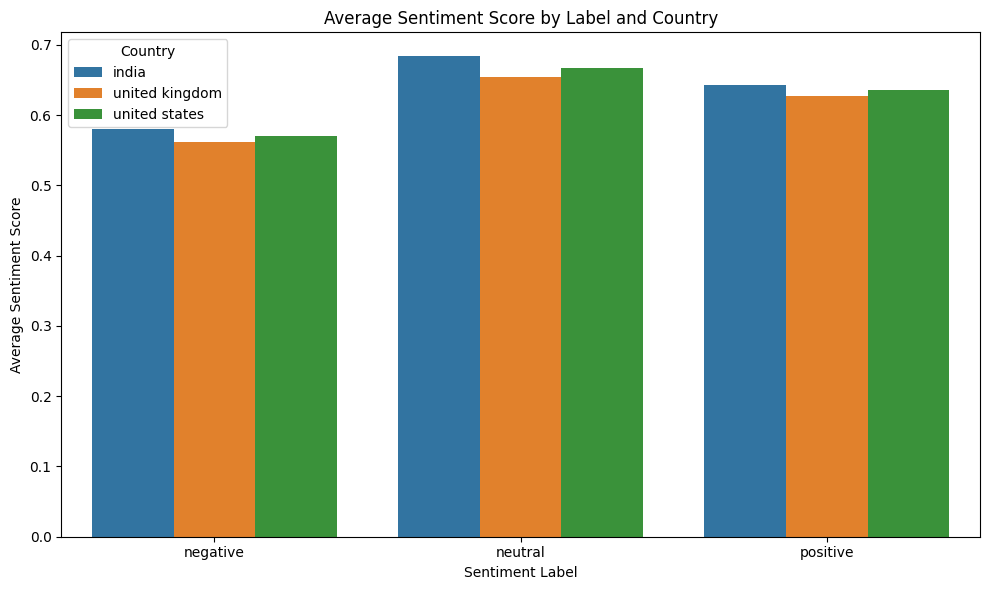

In [ ]:
# Keep only the three selected countries
countries = ['united states', 'united kingdom', 'india']
subset = merged_df[merged_df['LocationCountry'].isin(countries)]

# Group by sentiment label and country, then calculate average sentiment score
grouped = (
    subset
    .groupby(['SentimentLabel', 'LocationCountry'])['SentimentScore']
    .mean()
    .reset_index()
)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(
    data=grouped,
    x='SentimentLabel',
    y='SentimentScore',
    hue='LocationCountry'
)

plt.title('Average Sentiment Score by Label and Country')
plt.xlabel('Sentiment Label')
plt.ylabel('Average Sentiment Score')
plt.legend(title='Country')
plt.tight_layout()
plt.show()


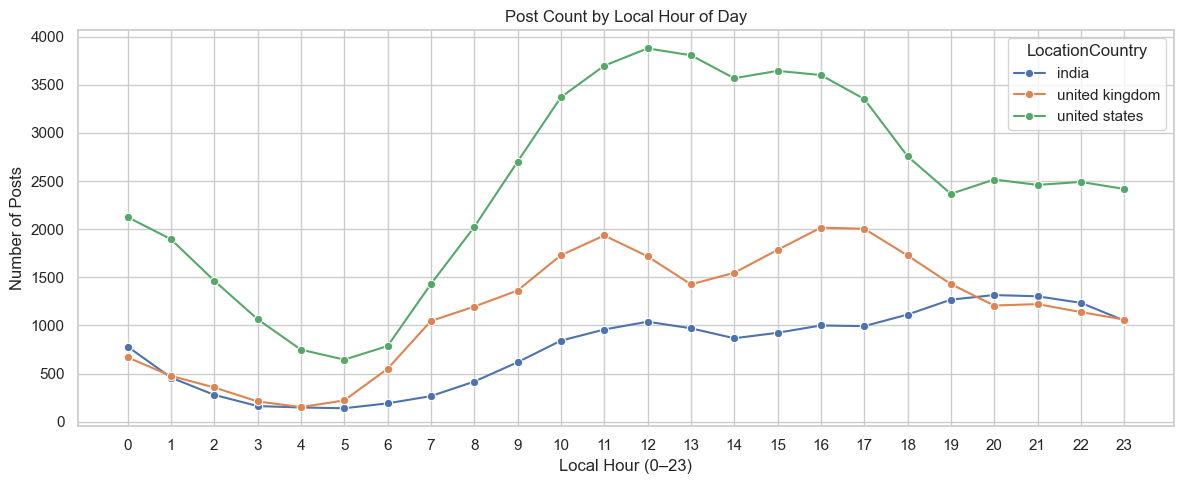

In [ ]:
from zoneinfo import ZoneInfo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define country-to-timezone mapping and weekday labels
timezone_map = {
    'united states': 'America/New_York',
    'united kingdom': 'Europe/London',
    'india': 'Asia/Kolkata'
}

weekday_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

# Step 2: Standardize country names to lowercase
merged_df['LocationCountry'] = merged_df['LocationCountry'].str.lower()
df = merged_df[merged_df['LocationCountry'].isin(timezone_map.keys())].copy()

# Step 3: Convert CreationDate to timezone-aware UTC datetime
df['CreationDate'] = pd.to_datetime(df['CreationDate'], errors='coerce').dt.tz_localize('UTC')

# Step 4: Convert UTC time to local time per country
df['LocalTime'] = df.apply(
    lambda row: row['CreationDate'].astimezone(
        ZoneInfo(timezone_map.get(row['LocationCountry'], 'UTC'))
    ),
    axis=1
)

# Step 5: Extract local hour and weekday
df['LocalHour'] = df['LocalTime'].apply(lambda x: x.hour if pd.notnull(x) else np.nan)
df['LocalWeekday'] = df['LocalTime'].apply(lambda x: x.weekday() if pd.notnull(x) else np.nan)

# Map weekday numbers to weekday names and order them
df['LocalWeekdayName'] = pd.Categorical(
    df['LocalWeekday'].map(weekday_map),
    categories=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    ordered=True
)

# Step 6: Group by local hour and country, and count the number of posts
hourly_local = df.groupby(['LocalHour', 'LocationCountry']).size().reset_index(name='PostCount')

# Step 7: Plot the number of posts by hour for each country
sns.set(style='whitegrid')
plt.figure(figsize=(12, 5))
sns.lineplot(data=hourly_local, x='LocalHour', y='PostCount', hue='LocationCountry', marker='o')
plt.title("Post Count by Local Hour of Day")
plt.xlabel("Local Hour (0–23)")
plt.ylabel("Number of Posts")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


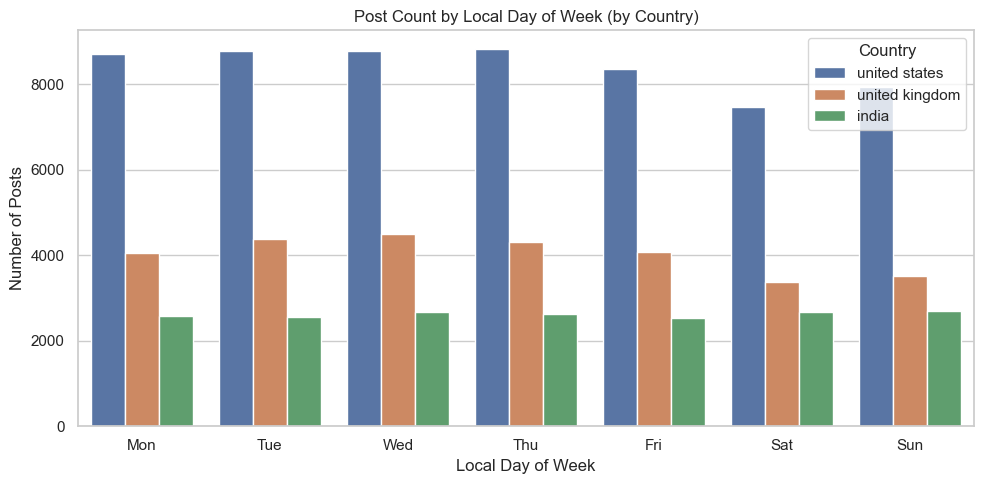

In [51]:
plt.figure(figsize=(10, 5))
sns.countplot(
    data=df,
    x='LocalWeekdayName',
    hue='LocationCountry',
    order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
plt.title("Post Count by Local Day of Week (by Country)")
plt.xlabel("Local Day of Week")
plt.ylabel("Number of Posts")
plt.legend(title='Country')
plt.tight_layout()
plt.show()


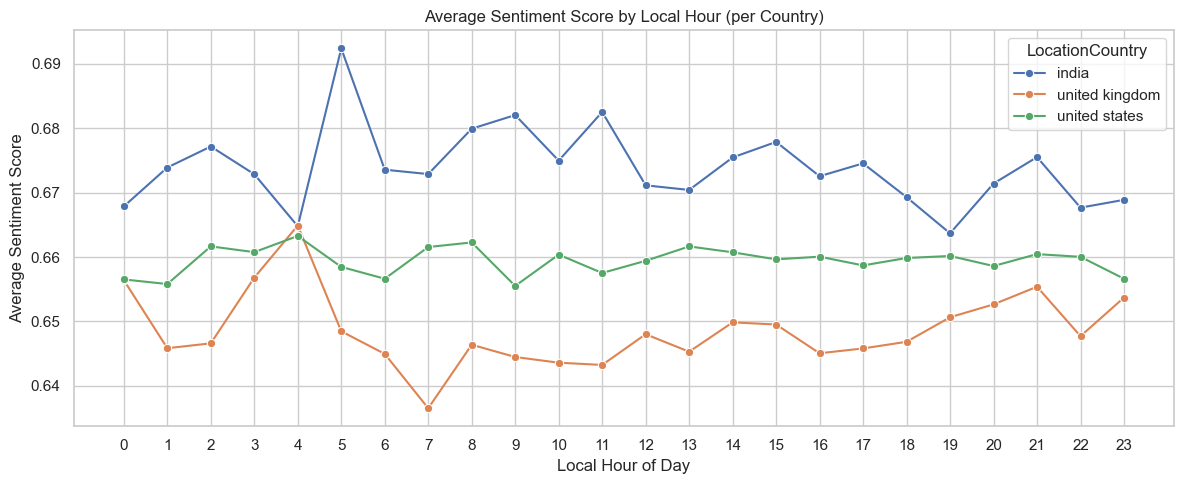

In [ ]:
# Group by local hour and country, and compute the average sentiment score
score_by_hour = (
    df.groupby(['LocalHour', 'LocationCountry'])['SentimentScore']
    .mean()
    .reset_index()
)

# Plot average sentiment score by hour for each country
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=score_by_hour,
    x='LocalHour',
    y='SentimentScore',
    hue='LocationCountry',
    marker='o'
)
plt.title("Average Sentiment Score by Local Hour (per Country)")
plt.xlabel("Local Hour of Day")
plt.ylabel("Average Sentiment Score")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()